In [457]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Attempting to create a GNN for the data

## Step 1: Load data

In [399]:
# load csvs
w1 = pd.read_csv('week1.csv')
w2 = pd.read_csv('week2.csv')
w3 = pd.read_csv('week3.csv')

In [400]:
w1.head()

,Unnamed: 0,source,genres,img_info,popularity,followers,collaborators,in_playlist,link,name,api_link,pagerank,closeness_cent,clustering,deg_cent,degree
0,Hanumankind,playlist,"['desi hip hop', 'indian underground rap', 'ma...",[{'url': 'https://i.scdn.co/image/ab6761610000...,76,503600,"{'Hanumankind': {'count': 14, 'uri': 'spotify:...",True,https://api.spotify.com/v1/artists/4nVa6XlBFlI...,Hanumankind,NaN,0.000159,0.258736,0.081871,0.000525,19
1,Kalmi,playlist,[],[{'url': 'https://i.scdn.co/image/ab6761610000...,75,32646,"{'Hanumankind': {'count': 3, 'uri': 'spotify:a...",True,https://api.spotify.com/v1/artists/6tYCSHLtTI5...,Kalmi,NaN,0.000145,0.258189,0.080882,0.000470,17
2,Parimal Shais,playlist,['malayalam hip hop'],[{'url': 'https://i.scdn.co/image/ab6761610000...,51,38998,"{'Parimal Shais': {'count': 17, 'uri': 'spotif...",False,NaN,Parimal Shais,NaN,0.000130,0.257790,0.114286,0.000415,15
3,Shalmali Kholgade,playlist,"['filmi', 'modern bollywood']",[{'url': 'https://i.scdn.co/image/ab6761610000...,63,155041,"{'Shalmali Kholgade': {'count': 20, 'uri': 'sp...",False,NaN,Shalmali Kholgade,NaN,0.000199,0.207056,0.008658,0.000608,22
4,Vishal Dadlani,playlist,"['filmi', 'modern bollywood']",[{'url': 'https://i.scdn.co/image/ab6761610000...,75,11840425,"{'Vishal Dadlani': {'count': 20, 'uri': 'spoti...",False,NaN,Vishal Dadlani,NaN,0.000265,0.206633,0.000000,0.000802,29


In [401]:
def get_weight(row:pd.Series):
    node_2 =row['edges']
    lookup = row['collaborators']
    if lookup=={}:
        return None
    return int(lookup[node_2]['count'])



In [402]:
def load_graph_fromcsv(df:pd.DataFrame):
    df.collaborators.fillna('{}',inplace=True)
    df['collaborators']=df.collaborators.apply(lambda x: ast.literal_eval(x))
    df['edges']=df.collaborators.apply(lambda x: list(x.keys()))
    df=df.explode('edges')
    df['weight']=df.apply(lambda x: get_weight(x),axis=1)
    return nx.from_pandas_edgelist(df=df,source='name',target='edges',edge_attr='weight')

In [403]:
w1_g = load_graph_fromcsv(w1)
w2_g = load_graph_fromcsv(w2)
w3_g = load_graph_fromcsv(w3)

In [404]:
# get features
w1_f = w1[['name','genres','popularity','followers']]
w2_f = w2[['name','genres','popularity','followers']]
w3_f = w3[['name','genres','popularity','followers']]
# get labels
w1_l = w1[['name','in_playlist']]
w1_l['in_playlist']=w1_l['in_playlist'].apply(lambda x: int(x))
w2_l = w2[['name','in_playlist']]
w2_l['in_playlist']=w2_l['in_playlist'].apply(lambda x: int(x))
w3_l = w3[['name','in_playlist']]
w3_l['in_playlist']=w3_l['in_playlist'].apply(lambda x: int(x))

/var/folders/r0/2fgtj8y934zddv46dgfbq1xw0000gn/T/ipykernel_727/2549947873.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w1_l['in_playlist']=w1_l['in_playlist'].apply(lambda x: int(x))
/var/folders/r0/2fgtj8y934zddv46dgfbq1xw0000gn/T/ipykernel_727/2549947873.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w2_l['in_playlist']=w2_l['in_playlist'].apply(lambda x: int(x))
/var/folders/r0/2fgtj8y934zddv46dgfbq1xw0000gn/T/ipykernel_727/2549947873.py:11: SettingWithCopyWarning: 
A value is trying to be se

In [405]:
# DROP GENRES FOR NOW, MAYBE ADD LATER
for node in w1_g.nodes:
    w1_g.nodes[node]['features']=w1_f[w1_f.name==node][['popularity','followers']].values
    w1_g.nodes[node]['label']=w1_l[w1_l.name==node]['in_playlist'].values

for node in w2_g.nodes:
    w2_g.nodes[node]['features']=w2_f[w2_f.name==node][['popularity','followers']].values
    w2_g.nodes[node]['label']=w2_l[w2_l.name==node]['in_playlist'].values

for node in w3_g.nodes:
    w3_g.nodes[node]['features']=w3_f[w3_f.name==node][['popularity','followers']].values
    w3_g.nodes[node]['label']=w3_l[w3_l.name==node]['in_playlist'].values

In [476]:
node_id_to_index = {node_id: idx for idx, node_id in enumerate(w1_g.nodes)}
# assigns a unique integer index (idx) to each node ID (node_id) in the graph G
# PyTorch Geometric works with numerically indexed nodes,
# so all node IDs from the NetworkX graph must be converted to numeric indices

# Create feature matrix and edge index
node_list = list(w1_g.nodes)
feature_temp = [w1_g.nodes[node]["features"].flatten().tolist() for node in node_list]
feature_mx = []
for x in feature_temp:
    if len(x)==0: # if there is no label, it isn't in playlist (a 3rd layer person)
        feature_mx.append([0,0]) # filling with 0, not best choice!! but might write about
    else:
        feature_mx.append(x)
feature_matrix = np.array(feature_mx,dtype=np.float64)
#feature_matrix = np.expand_dims(feature_matrix,axis=1) # make sure its the right shape

# Normalize node features - so that sum equals 1 and all features are on the same scale
# SKYELER COME CHECKTHIS LATER!!!! 
#feature_matrix = feature_matrix/feature_matrix.sum(axis=1,keepdims=True)
feature_matrix = feature_matrix/feature_matrix.sum(axis=0)


In [477]:
#creates node labels
temp = [w1_g.nodes[node]['label'].tolist() for node in node_list] # get the labels
labels = []
for x in temp:
    if len(x)==0: # if there is no label, it isn't in playlist (a 3rd layer person)
        labels.append(0)
    else:
        labels.append(x[0])
labels = torch.tensor(labels,dtype=torch.long)

In [478]:
# Create edge index
edge_index = torch.tensor(
    [[node_id_to_index[src], node_id_to_index[dst]] for src, dst in w1_g.edges],
    dtype=torch.long,
).t().contiguous()

# Create PyTorch Geometric Data object
data = Data(
    x=torch.tensor(feature_matrix, dtype=torch.float),
    edge_index=edge_index,
    y=labels
)

In [479]:
# Train/Test Split
node_indices = np.arange(data.num_nodes)
train_indices, test_indices = train_test_split(
    node_indices, test_size=0.3, random_state=42
)
# Further split training nodes into train/validation sets
train_indices, val_indices = train_test_split(train_indices, test_size=0.2, random_state=42)

# Convert Splits to PyTorch Tensors
train_nodes = torch.tensor(train_indices, dtype=torch.long)
val_nodes = torch.tensor(val_indices, dtype=torch.long)
test_nodes = torch.tensor(test_indices, dtype=torch.long)

In [480]:
label_mapping = {1:'yes',0:'no'}

In [481]:
# Define the GNN Model
# 2-layer Graph Convolutional Network (GCN) is defined using GCNConv layers
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim,hidden_dim) # layer 1 - takes the input node features (input_dim) and aggregates information from neighboring nodes
        self.conv2 = GCNConv(hidden_dim,output_dim) # layer 2 - Maps the hidden representation from the first layer to the output dimensions (number of classes)
        self.dropout = dropout # prevents overfitting by randomly dropping nodes in fws pass

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x) # for non-linearity
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1) # gives log probabilities for each class -> used for classification 


model = GCN(
    input_dim=2, #data.x.size(1),  # Number of features
    hidden_dim=16,
    output_dim=len(label_mapping),  # Number of classes
    dropout=0.5,  # Dropout rate
)

In [482]:
# defines the Validation Function
def validate():
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        correct_pred = (pred[val_nodes]==data.y[val_nodes]).sum() #.items
        return f1_score(data.y[val_nodes],pred[val_nodes]),correct_pred/len(val_nodes)
        #return correct_pred/len(val_nodes)

# Training and Testing Loops
# Optimizes the model’s parameters during training
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [483]:
# ensures the model’s weights are properly initialized to avoid issues like exploding/vanishing gradients
def initialize_weights(m):
    # Initialize the weight of the linear layer inside GCNConv
    if isinstance(m,GCNConv):
        torch.nn.init.xavier_uniform_(m.lin.weight) # inits weight

model.apply(initialize_weights)

GCN(
  (conv1): GCNConv(2, 16)
  (conv2): GCNConv(16, 2)
)

In [484]:
# Trains the model using the negative log-likelihood loss and updates weights using backpropagation
def train():
    model.train() # Sets the model to training mode
    optimizer.zero_grad() # Resets the gradients from the previous step
    out = model(data) # Forward pass: computes model predictions
    loss = F.nll_loss(out[train_nodes], data.y[train_nodes]) # Computes loss on training nodes
    loss.backward() # Backward pass: computes gradients of the loss with respect to model parameters
    optimizer.step() # Updates model parameters
    return loss # Returns the loss for tracking

In [485]:
# Evaluates the model’s performance on the test set
def test():
    model.eval()  # Sets the model to evaluation mode
    with torch.no_grad():  # Disables gradient calculations
        _, pred = model(data).max(dim=1)
        # Predicts the class with the highest probability
        corr = (pred[test_nodes]==data.y[test_nodes]).sum()
          # Counts correct predictions for test nodes
        acc = int(corr)/len(test_nodes)
          # Calculates accuracy
        f1 = f1_score(data.y[test_nodes],pred[test_nodes])
    return f1,acc  # Returns the test accuracy

In [486]:
# Training the Model
# 100 epochs 
# monitors the loss and test accuracy every 10 seconds
train_losses, val_accuracies, test_accuracies, val_f1, test_f1 = [], [], [], [], []
best_model = None
best_val_acc = 0

# SKYELER UPDATE NOT ACC now F1

# Training and Validation Loop

# train() -> trains the model for one epoch (one pass over the training data). Returns the training loss for the epoch
for epoch in range(500):
    # Evaluates the model on the validation set
    loss = train()
    val_f1acc = validate()
    v_f1 = val_f1acc[0]
    v_acc = val_f1acc[1]
    #test
    test_f1acc = test()
    t_f1 = test_f1acc[0]
    t_acc = test_f1acc[1]
    
    # Saving metrics
    train_losses.append(loss.item())
    val_accuracies.append(v_acc)
    test_accuracies.append(t_acc)
    val_f1.append(v_f1)
    test_f1.append(t_f1)
    
    # Save the best model based on validation accuracy
    # if the current validation accuracy (val_acc) is higher than best_val_acc, the model’s parameters are saved
    if v_acc > best_val_acc:
        best_model = model.state_dict()
        best_val_acc = v_acc
    
    # Log Epoch Progress
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.9f}, Val F1: {v_f1:.9f}, Test F1: {t_f1:.9f}, Val Acc {v_acc:.9f}, Test Acc {t_acc:.9f}")



Epoch 0, Loss: 0.693124831, Val F1: 0.000000000, Test F1: 0.000000000, Val Acc 0.996045291, Test Acc 0.996895973
Epoch 10, Loss: 0.466771364, Val F1: 0.000000000, Test F1: 0.000000000, Val Acc 0.996045291, Test Acc 0.996895973
Epoch 20, Loss: 0.260662138, Val F1: 0.000000000, Test F1: 0.000000000, Val Acc 0.996045291, Test Acc 0.996895973
Epoch 30, Loss: 0.135839656, Val F1: 0.000000000, Test F1: 0.000000000, Val Acc 0.996045291, Test Acc 0.996895973
Epoch 40, Loss: 0.077617228, Val F1: 0.000000000, Test F1: 0.000000000, Val Acc 0.996045291, Test Acc 0.996895973
Epoch 50, Loss: 0.057287715, Val F1: 0.000000000, Test F1: 0.000000000, Val Acc 0.996045291, Test Acc 0.996895973
Epoch 60, Loss: 0.048630193, Val F1: 0.000000000, Test F1: 0.000000000, Val Acc 0.996045291, Test Acc 0.996895973
Epoch 70, Loss: 0.044264317, Val F1: 0.000000000, Test F1: 0.000000000, Val Acc 0.996045291, Test Acc 0.996895973
Epoch 80, Loss: 0.039657939, Val F1: 0.000000000, Test F1: 0.000000000, Val Acc 0.9960452

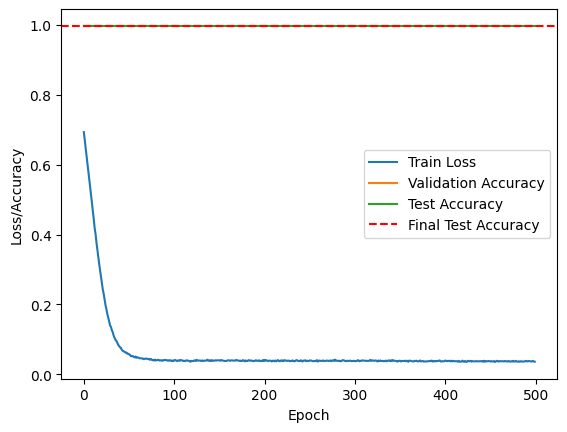

Final Training Loss: 0.0362167917
Best Validation Accuracy: 0.9960452914
Final Test Accuracy: 0.9968959732


In [487]:
# plots training loss and accuracies

plt.plot(train_losses, label='Train Loss')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.axhline(y=test_accuracies[-1], color='r', linestyle='--', label='Final Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

# Final Summary
print(f"Final Training Loss: {train_losses[-1]:.10f}")
print(f"Best Validation Accuracy: {best_val_acc:.10f}")
print(f"Final Test Accuracy: {test_accuracies[-1]:.10}")